In [16]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [17]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

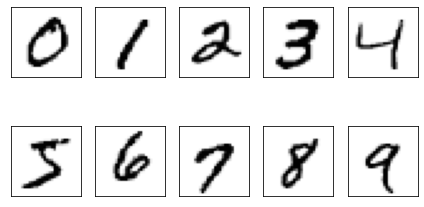

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

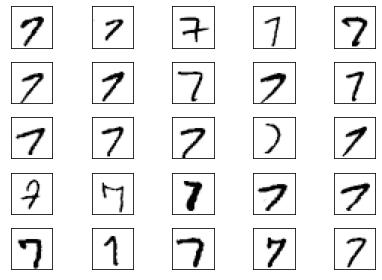

In [19]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [20]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [21]:
import numpy as np

In [240]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        self.weight_hh = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_hh = np.zeros(num_hidden)
        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # First Layer 
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        act_h = sigmoid(z_h)
        # Second Layer 
        z_hh = np.dot(act_h, self.weight_hh.T) + self.bias_hh
        act_hh = sigmoid(z_hh)
        z_out = np.dot(act_hh, self.weight_out.T) + self.bias_out
        act_out = sigmoid(z_out)
        return act_h, act_hh, act_out

    def update(self, grad, lr):
        self.weight_h -= lr * grad[0]
        self.bias_h -= lr * grad[1]
        
        self.weight_hh -= lr * grad[2]
        self.bias_hh -= lr * grad[3]
        
        self.weight_out -= lr * grad[4]
        self.bias_out -= lr * grad[5]
    
    
    def backward(self, x, act_h, act_hh, act_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # dLoss/dWeightsOut = dLoss/dActOut * dActOut/dZOut * dZOut/dWOut
        dLoss_dActOut =  2.*(act_out - y_onehot) / y.shape[0]
        dActOut_dZOut =  act_out * (1. - act_out)
        # dloss/dzout
        dLoss_dZOut = dLoss_dActOut * dActOut_dZOut
        dZOut_dWOut = act_hh
        # Lets Multiply
        dLoss_dWOut = np.dot(dLoss_dZOut.T,dZOut_dWOut)
        dLoss_dBOut = np.sum(dLoss_dZOut, axis=0)
        
        #########################
        ### Middle layer weights
        #########################
        # dLoss/dWeightsHH = dLoss/dZOut * dZOut/dActHH * dActHH/dZHH * dZHH/dWHH
        dZOut_dActHH = self.weight_out
        dLoss_dActHH = np.dot(dLoss_dZOut,dZOut_dActHH)
        dActHH_dZHH =  act_hh * (1. - act_hh)
        dZHH_dWHH = act_h
        dLoss_dZHH = dLoss_dActHH * dActHH_dZHH
        # Lets Multiply
        dLoss_dWeightsHH = np.dot(dLoss_dZHH.T,dZHH_dWHH)
        dLoss_dBHH = np.sum(dLoss_dZHH, axis=0)
        

        #########################
        ### First layer weights
        #########################
        # dLoss/dWeightsH = dLoss/dZOHH * dZHH/dActH * dActH/dZH * dZH/dWH
        dZHH_dActH = self.weight_hh
        dLoss_dActH = np.dot(dLoss_dZHH,dZHH_dActH)
        dActH_dZH =  act_h * (1. - act_h)
        dZH_dWH = x
        dLoss_dZH = dLoss_dActH * dActH_dZH
        # Lets Multiply
        dLoss_dWeightsH = np.dot(dLoss_dZH.T,dZH_dWH)
        dLoss_dBH = np.sum(dLoss_dZH, axis=0)
        
        return (dLoss_dWeightsH, dLoss_dBH, dLoss_dWeightsHH, dLoss_dBHH, dLoss_dWOut ,dLoss_dBOut)

In [241]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [242]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [243]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

_,_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [244]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [245]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.0%


In [246]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            ### Foward ###
            act_h,act_hh,act_out = model.forward(X_train_mini)
            ### Backward ### 
            gradient = model.backward(X_train_mini,act_h,act_hh,act_out,y_train_mini)
            ### Update Weights
            model.update(gradient,learning_rate)
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [247]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 18.53% | Valid Acc: 18.50%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 28.39% | Valid Acc: 28.42%
Epoch: 003/050 | Train MSE: 0.07 | Train Acc: 43.50% | Valid Acc: 43.94%
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 63.36% | Valid Acc: 63.78%
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 72.16% | Valid Acc: 71.82%
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 83.30% | Valid Acc: 83.30%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 86.24% | Valid Acc: 86.02%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 87.77% | Valid Acc: 87.74%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 88.78% | Valid Acc: 88.74%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 89.42% | Valid Acc: 89.46%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 89.96% | Valid Acc: 89.94%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 90.39% | Valid Acc: 90.22%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 90.74% | Valid Acc: 90.60%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 91.21

## Evaluating the neural network performance

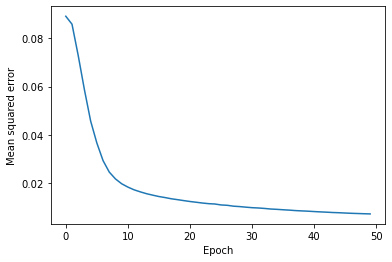

In [248]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

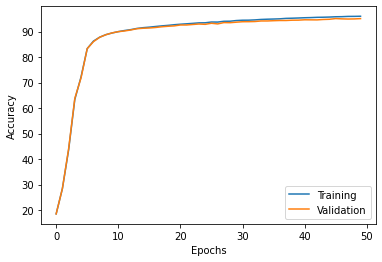

In [249]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [250]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.84%


Plot failure cases:

In [252]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_,_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

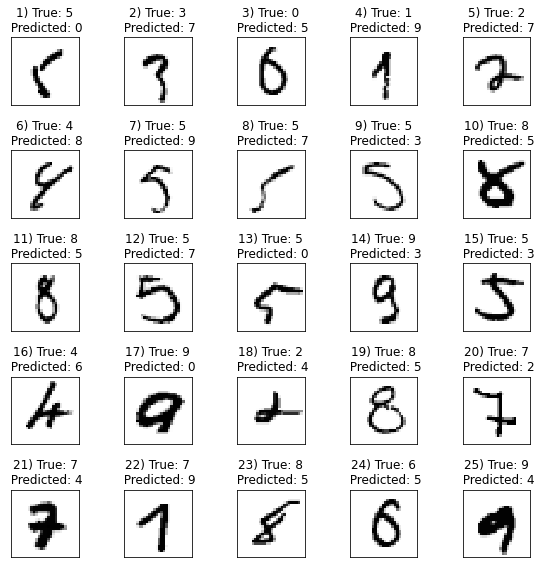

In [254]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>